In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of skaro, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skaro.model import Model
from skaro.utilities.math import calculate_pca
from skaro.utilities.dataframe import (
    aggregated_dataframe,
    rename_labels,
    rename_entries,
)
from skaro.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    ridgeplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo

yt : [INFO     ] 2023-11-10 15:34:25,016 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-11-10 15:34:25,175 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-11-10 15:34:25,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-10 15:34:25,177 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-10 15:34:25,177 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-11-10 15:34:25,178 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-10 15:34:25,179 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-11-10 15:34:25,179 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-11-10 15:34:25,180 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-11-10 15:34:25,181 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-11-10 15:34:25,183 Parameters: hubble_constant      

yt : [INFO     ] 2023-11-10 15:34:26,542 Allocating for 4.654e+08 particles
Loading particle index: 100%|██████████| 587/587 [00:00<00:00, 1119.00it/s]

      FIELDS: Adding field ('PartType4', 'InitialMass'), with masses in  'code_mass'.


      STARS: 'stars' field derives from PartType4 field in age range: [0.02, inf] Gyr.


      TIMER: Block 'Adding Stars...' took 6.13 seconds.


      TIMER: Block 'Adding Planets...' took 4.19 seconds.


      TIMER: Block 'Loading Particle IDs...' took 1.73 seconds.


      DECOMPOSITION: Loading decomposition file.


      TIMER: Block 'Galaxy Decomposition...' took 0.71 seconds.



## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Galaxy_components"
save = True

## CREATE DATA SOURCE

In [7]:
radius = 0.2 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

In [8]:
components = ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"]
data = aggregated_dataframe(
    components,
    [
        "[Fe/H]",
        "stellar_age",
        "Masses",
    ],
    data_source=sphere_data,
    type_name="Component",
    custom_units={"stellar_age": "Gyr"},
)

# filtering values
filters = {"[Fe/H]": (-2.5, 1)}
for field_value, ranges in filters.items():
    data = data[data[field_value].between(*ranges)]

# rename labels and components
data = rename_entries(data)
data, labels = rename_labels(data)

## FRACTION OF MASS IN COMPONENTS

In [9]:
data.groupby("Component")["Masses"].sum()

Component
Bulge         1.575101e+10
Halo          4.317865e+09
Thick Disk    3.488819e+09
Thin Disk     3.490806e+10
Name: Masses, dtype: float64

In [10]:
data.groupby("Component")["Masses"].sum() / data["Masses"].sum()

Component
Bulge         0.269406
Halo          0.073853
Thick Disk    0.059673
Thin Disk     0.597069
Name: Masses, dtype: float64

## STELLAR AGE IN COMPONENTS

In [11]:
data.groupby("Component")[labels["stellar_age"]].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,706721.000000,187110.000000,154127.000000,1.498314e+06
mean,8.611060,9.660903,8.475875,5.996949e+00
std,2.470763,2.052055,2.012150,2.438352e+00
min,0.021317,0.030658,0.026203,2.001893e-02
25%,7.057361,8.609357,7.074107,4.637184e+00
50%,9.048227,9.939772,8.666834,6.088776e+00
75%,10.424666,11.067633,9.860861,7.583421e+00
max,13.509129,13.484454,13.509129,1.346309e+01


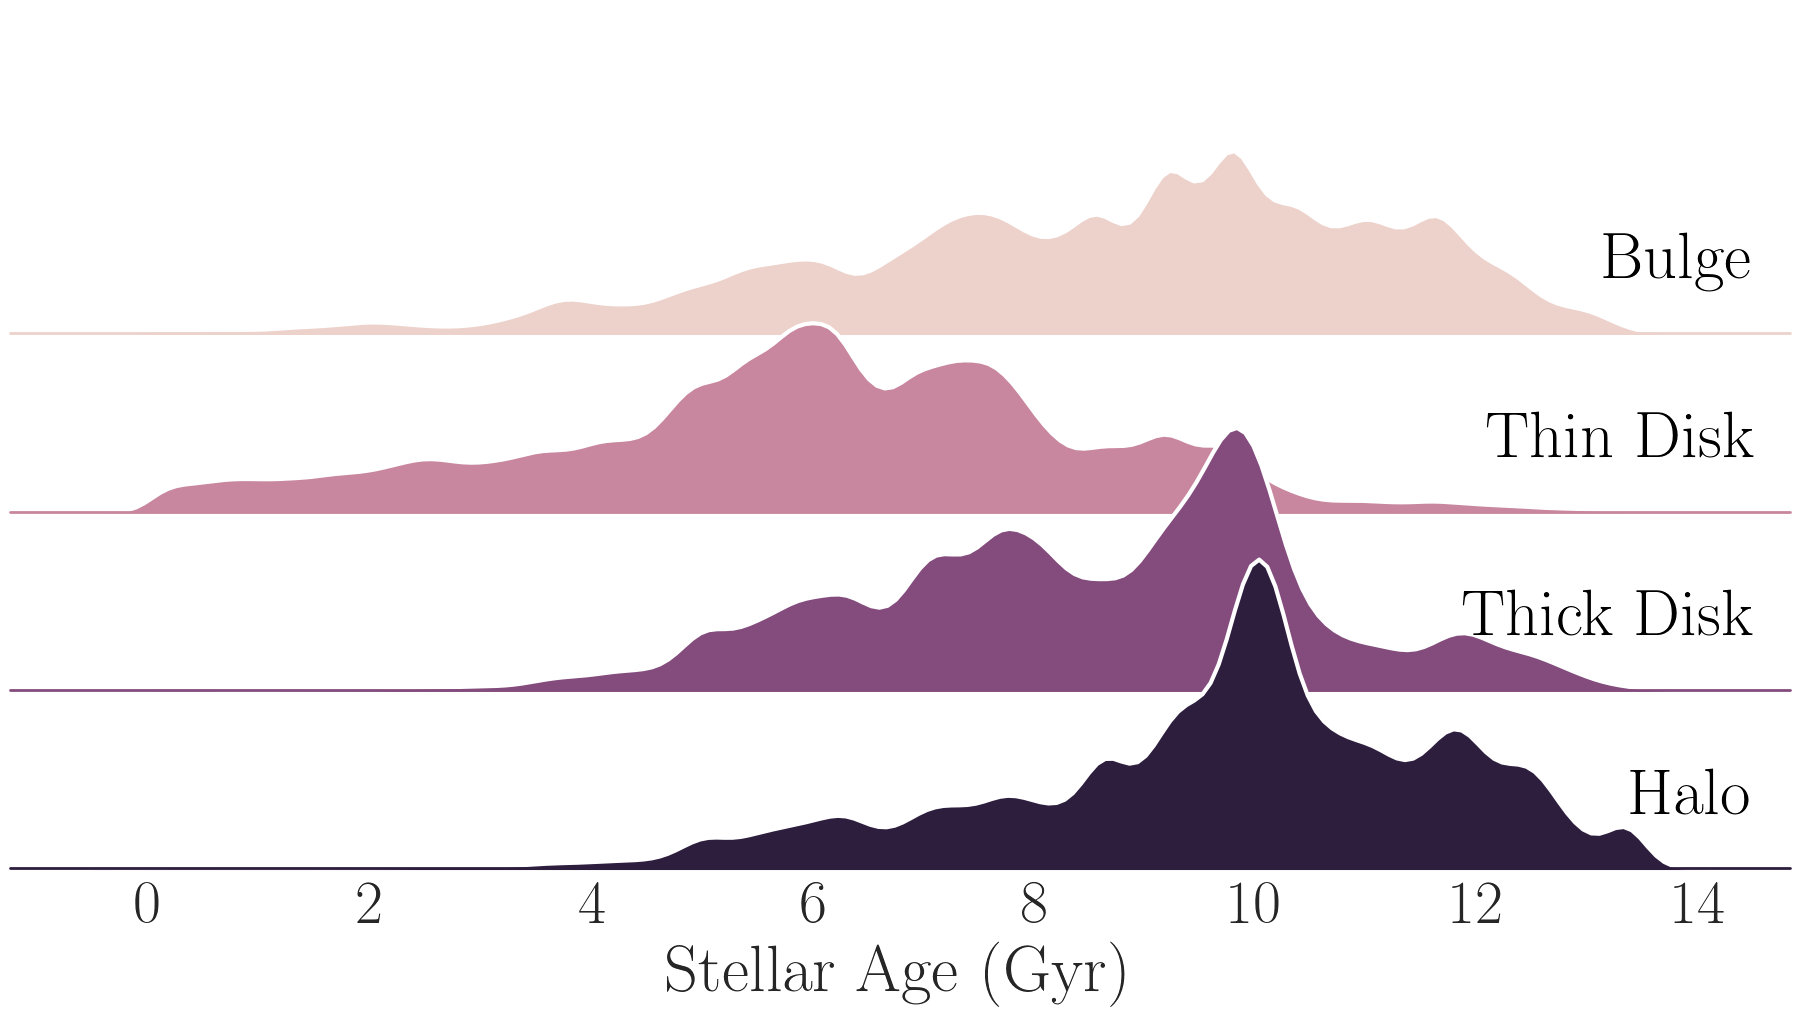

In [12]:
ridgeplot_age = ridgeplot(
    data,
    x=labels["stellar_age"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.98, 0.22],
)
FigureProcessor(ridgeplot_age.figure).save(
    "ridgeplot_age.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## METALLICITY IN COMPONENTS

In [13]:
data.groupby("Component")["[Fe/H]"].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,706721.000000,187110.000000,154127.000000,1.498314e+06
mean,-0.031813,-0.745312,-0.553937,1.625172e-02
std,0.471899,0.420949,0.326932,3.256640e-01
min,-2.497954,-2.499774,-2.497884,-2.499517e+00
25%,-0.349643,-0.942939,-0.678044,-1.867511e-01
50%,-0.032655,-0.678103,-0.485417,1.708098e-02
75%,0.339839,-0.467940,-0.350491,2.399487e-01
max,0.999591,0.881223,0.882561,9.994379e-01


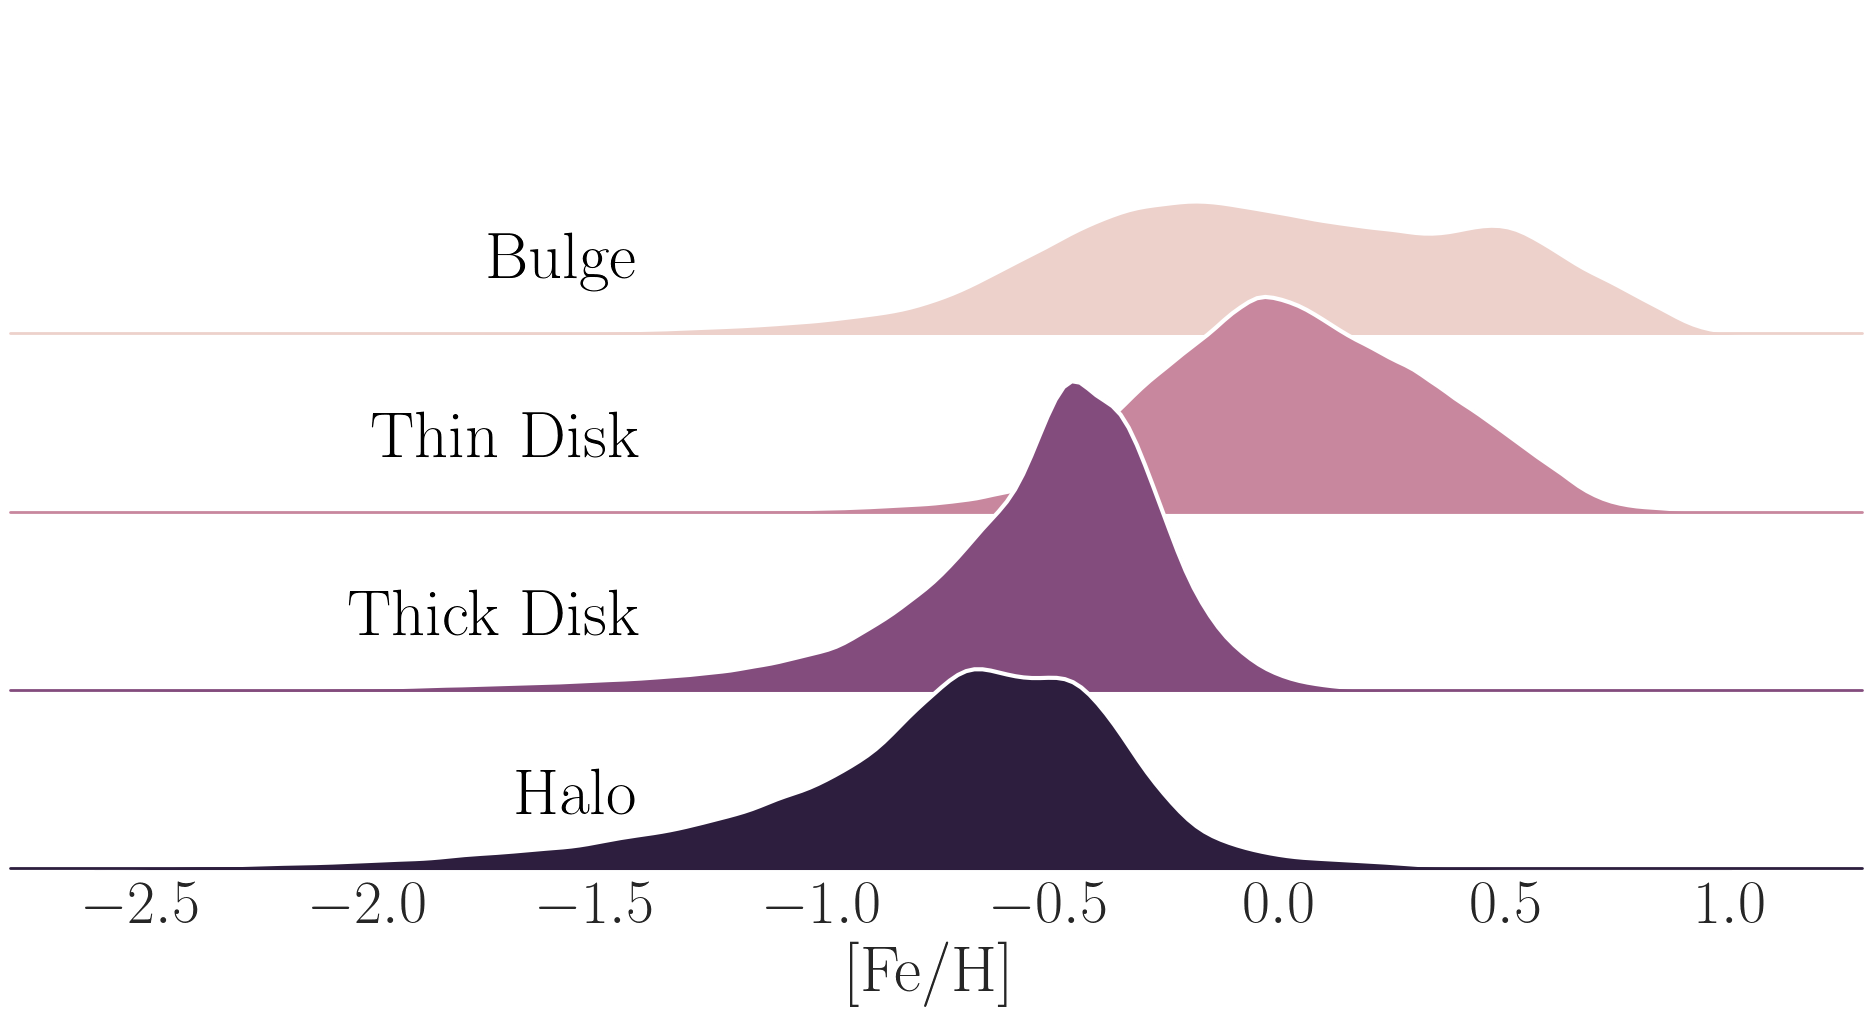

In [14]:
ridgeplot_metallicity = ridgeplot(
    data,
    x=labels["[Fe/H]"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.34, 0.22],
)
FigureProcessor(ridgeplot_metallicity.figure).save(
    "ridgeplot_metallicity.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## PRICIPAL COMPONENTS

In [15]:
variance_ratios = pd.DataFrame(
    np.array(
        [
            calculate_pca(
                sphere_data[component, "particle_position"].to("kpc")
            ).explained_variance_ratio_
            for component in components
        ]
    ).T,
    columns=components,
).T

print("Minor-to-major axis ratio:")
print(variance_ratios[2] / variance_ratios[0])

Minor-to-major axis ratio:
bulge_stars         0.347155
thin_disk_stars     0.057898
thick_disk_stars    0.384012
halo_stars          0.622306
dtype: float64
